### Dependencies

In [18]:
# System and Versioning libraries
import sys
import importlib
from packaging import version

# File Management libraries
import tarfile
import urllib.request
from pathlib import Path

# ML libraries
import sklearn
import pandas as pd

# Data Analytics libraries
import matplotlib.pyplot as plt

# Custom libraries
import utils as ut

Reloading custom libraries

In [6]:
importlib.reload(ut)

<module 'utils' from 'e:\\david\\Documents\\ML-Projects\\supervised_regression\\utils.py'>

Checking if the Python version is 3.7 or above

In [4]:
print(sys.version)
assert sys.version_info >= (3,7)

3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


Checking if the Scikit-Learn version is 1.0.1 or above

In [5]:
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse('1.0.1')

1.3.2


### Data Extraction

Downloading data and creating directories

In [7]:
ut.downloadHousingData()

data/ directory created
data downloaded from https://github.com/ageron/data/raw/main/housing.tgz
Content Extracted into data/


Creating the dataframe

In [8]:
housingDf = pd.read_csv('data/housing.csv')

Viewing data

In [9]:
housingDf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Dataframe Information

Checking dataframe info

In [10]:
housingDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The ocean_proximity column is an object data type, so is important to check its values

In [12]:
housingDf['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

Obtaining descriptive statistics for numeric data

In [11]:
housingDf.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plotting histograms for numerical data

**Important**: Median income values are tens of thousands of dollars. For example, 3 means 30,000 Annual avarage income. This feature is also capped.

* Upper cap: 15
* Lower cap: 0.5

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

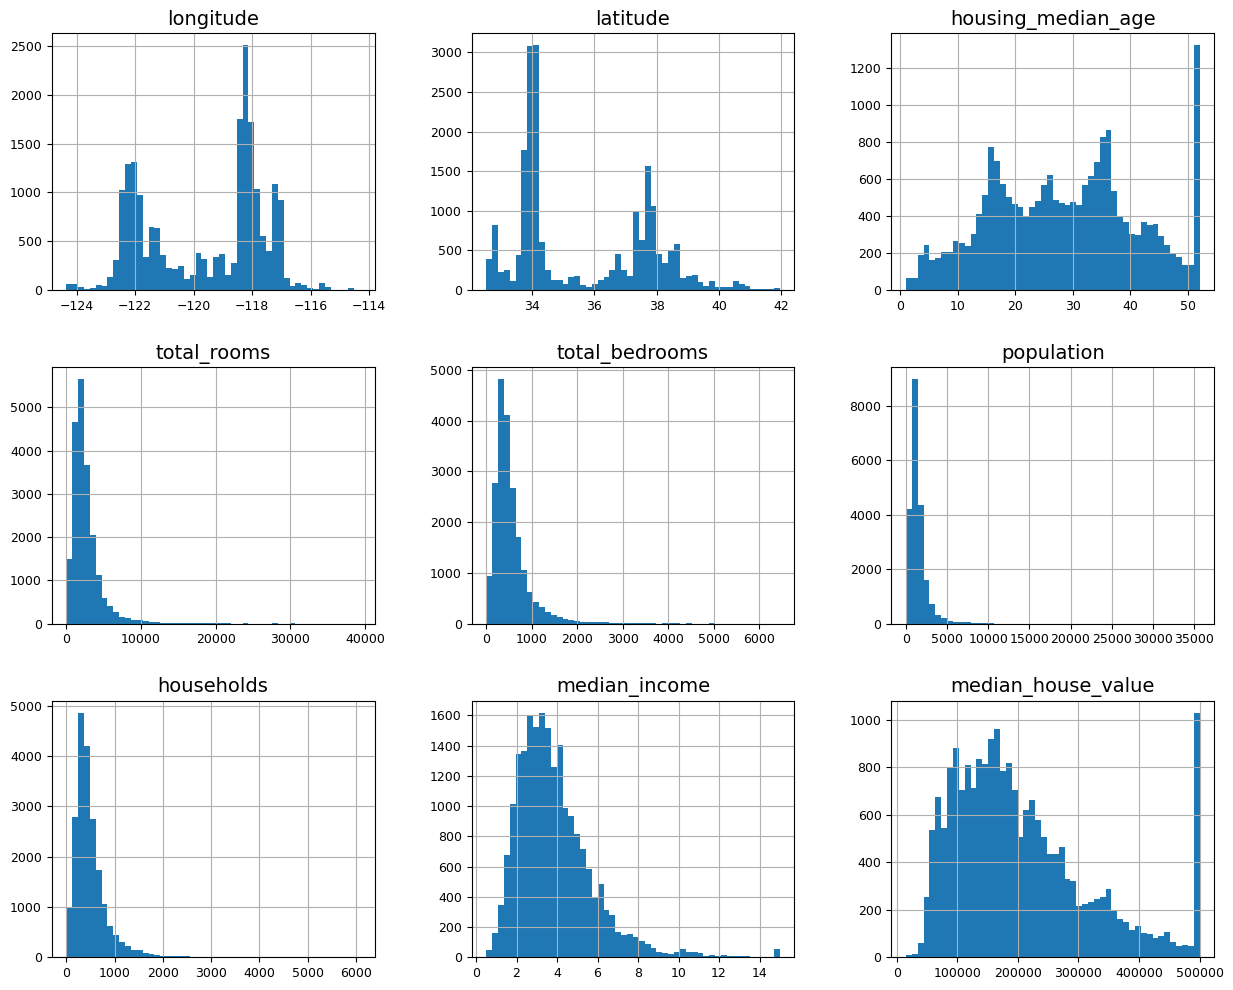

In [22]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

housingDf.hist(bins=50, figsize=(15,12))